# Collaborative Filtering Recommender Systems

* $u \in Users$ - Пользователи, $|Users| = n$
* $i \in Items$ - Продукты, $|Items| = m$
* $r_{i,j} \in Ratings = Users * Items$ - Рейтинги,  $|Ratings| = m*n$

## Intro

Представим, что мы имеем онлайн-кинотеатр, в котором пользователи смотрят фильмы, ставят им рейтинги, пишут к ним рецензии итд. Нас попросили улучшить пользовательский опыт использования (experience) этого сервиса путем создания рекомендательной системы, которая будет рекомендовать фильмы,которые могут понравится пользователям, в виде списка. <br>
Выделяют следующие подвиды Collaborative Filtering: 
* User-Based
* Item-Based (Content-Based)

## User-Based 

Основная идея данного подхода заключается в следующем: пользователи, которым нравятся похожие продукты (фильмы, места, песни итд.) скорее всего имеют одиннаковые вкусы. И этой информации в принципе нам уже достаточно, чтобы дать рекоммендацию пользователю. Ему можно рекоммендовать что-то с чем он еще не сталкивался, но людям с похожими вкусами его оценили высоко. В данном случае мы учитываем **только рейтинги пользователей в системе**, мы не учитываем личные характеристики пользователей (пол, возраст, страна итд) и не учитываем характеристики самих продуктов.

P.S.
Для новых пользователей такой подход не сработает по той простой причине, что у них еще нет истории взаимодействий. Такая проблема называется **Cold Start Problem**. Мы не будем рассматривать такие случаи, но ее можно решить выдав популярные продукты в системе

In [1]:
import pandas as pd
from scipy import spatial

In [2]:
exmpl = pd.DataFrame(
    {
        'Movie1': [4, 4, 5, 3],
        'Movie2': [3, 5, 2, 5], 
        'Movie3': [2, 5, 4, None],
        'Movie4': [4, 2, 3, None]
    }, index=['User1', 'User2', 'User3', 'User4'])

In [3]:
exmpl

,Movie1,Movie2,Movie3,Movie4
User1,4,3,2.0,4.0
User2,4,5,5.0,2.0
User3,5,2,4.0,3.0
User4,3,5,NaN,NaN


Для **User4** не определен рейтинг для фильмов **Movie3** и **Movie4**. Однако, рейтинги фильмов Movie1 и Movie2 примерно похожи с **User1**. Можно сделать предположение, что **Movie3** окажется хорошей рекомендацие, а **Movie4** - нет.

Но давайте обозначим более формально, то как мы будем считать, что пользователи похожи друг на друга.

In [4]:
exmpl[['Movie1', 'Movie2']].values

array([[4, 3],
       [4, 5],
       [5, 2],
       [3, 5]])

Text(0, 0.5, 'Movie2')

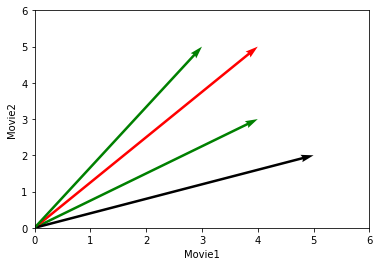

In [5]:
import matplotlib.pyplot as plt
import numpy as np

vectors = np.array(([2, 0], [3, 2]))
vector_addition = vectors[0] + vectors[1]
vectors = exmpl[['Movie1', 'Movie2']].values
 
tail = [0, 0]
fig, ax = plt.subplots(1)
ax.quiver(*[[0, 0, 0, 0], [0, 0, 0, 0]],
           vectors[:, 0],
           vectors[:, 1],
           scale=1,
           scale_units='xy',
           angles = 'xy',
           color=['g', 'r', 'k'])
 
ax.set_xlim((0, vectors[:,0].max()+1))
ax.set_xlabel('Movie1')
ax.set_ylim((0, vectors[:,1].max()+1))
ax.set_ylabel('Movie2')

Нам нужна функция, которая будет определять "похожесть". Для малых углов возвращает бОльшее значение и для бОльших углов меньшее значение. Как вы уже возможно догадались косинусное расстояние хорошо для этого подходит

### Косинусное расстояние 

$$Cosine\, similarity : Sim(u_x, u_y) = \frac{r_x, r_y}{|r_x|*|r_y|} $$

In [6]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
user4 = vectors[-1]

In [8]:
for pair in vectors:
    print(pair, spatial.distance.cosine(user4, pair))

[4 3] 0.07390764023045227
[4 5] 0.009007569589676745
[5 2] 0.20383780587689748
[3 5] 0.0


### Формула Пирсона

$$r_{xy}=\frac{\Sigma(x_i-\bar{M_x})\times(y_i-\bar{M_y})}{\sqrt{\Sigma(x_i-\bar{M_x})^2\times\Sigma(y_i-\bar{M_y})^2}}$$
*, где $\bar{M_x}$ - средние оценки для пользователя x, $\bar{M_y}$ - средние оценки для пользователя y*

In [11]:
# TODO
# from surprise import Dataset
# !pip install scikit-surprise
# movielens = Dataset.load_builtin('ml-100k')
# trainingSet = movielens.build_full_trainset()

Для опытов возьмем датасет MovieLens

In [12]:
users_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')

In [13]:
users_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [14]:
users = pd.read_csv('data/ml-100k/u.user', names=['user_id','movie_id','rating'], sep='|')

In [15]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')

In [16]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [17]:
movies = users_ratings[['movieId']].drop_duplicates().sort_values('movieId').head(5)
users=users_ratings[['userId']].drop_duplicates().sort_values('userId').head(5)

In [18]:
def standirdize(row):
    return (row - row.mean())/(row.max() - row.min())

In [19]:
df_all_ratings = users_ratings.pivot_table(values='rating', index='userId', columns='movieId')

In [20]:
df_all_ratings.fillna(0, inplace=True)

In [21]:
df_ratings_std = df_all_ratings.apply(standirdize)

In [22]:
item_similarity = cosine_similarity(df_ratings_std.T)

In [23]:
df_item_similarity = pd.DataFrame(item_similarity, index=df_all_ratings.columns, columns=df_all_ratings.columns)

In [24]:
def get_similar_movies(movie_id, user_rating):
    # домножаем на константу (user_rating - 3), считая что 3 это порог, того что фильм понравился пользователю
    simillar_score = df_item_similarity[movie_id]*(user_rating - 3) 
    simillar_score = simillar_score.sort_values(ascending=False)
    return simillar_score

In [37]:
# 
my_ratings = [
    (58559, 5), # The Dark Knight (2008)
    (1, 5), # Toy Story 
    (593, 4), # Ace Ventura: When Nature Calls
    (1562, 1), # Batman & Robin (1997)
    (1732, 5), # Big Lebowski, The (1998,
    (356, 5), # Forrest Gump (1994),
    (4041, 4), # Officer and a Gentleman, An (1982),
    (53996, 2), # Transformers: Dark of the Moon (2011)
    (5989, 5), # Catch Me If You Can (2002)
    (102716, 1), # Fast & Furious 6
    (1198, 5), # Raiders of the Lost Ark 
    (1196, 5), # Star Wars: Episode V - The Empire Strikes Back
    (1210, 2), # Star Wars: Episode VI 
    (293, 5) # Léon: The Professional 
]

In [27]:
movie_ids, ratings = list(zip(*my_ratings))

In [28]:
df_movies[df_movies['title'].str.contains('Batman')]

,movieId,title,genres
126,153,Batman Forever (1995),Action|Adventure|Comedy|Crime
509,592,Batman (1989),Action|Crime|Thriller
1060,1377,Batman Returns (1992),Action|Crime
1174,1562,Batman & Robin (1997),Action|Adventure|Fantasy|Thriller
2418,3213,Batman: Mask of the Phantasm (1993),Animation|Children
5463,26152,Batman (1966),Action|Adventure|Comedy
5620,27155,"Batman/Superman Movie, The (1998)",Action|Adventure|Animation|Children|Fantasy|Sc...
5631,27311,Batman Beyond: Return of the Joker (2000),Action|Animation|Crime|Sci-Fi|Thriller
5917,33794,Batman Begins (2005),Action|Crime|IMAX
6815,60979,Batman: Gotham Knight (2008),Action|Animation|Crime


In [29]:
# получаем похожие фильмы по оценке просмотренных
rec_movies = pd.DataFrame()
for movie_id, rating in my_ratings:
    rec_movies = rec_movies.append(get_similar_movies(movie_id, rating))

In [30]:
# проссумируем все столбцы и упорядочим
rec_movies_sorted = rec_movies.sum().sort_values(ascending=False)
# убираем фильмы, которым уже были просмотренны и получили оценку
rec_movies_sorted = rec_movies_sorted[~rec_movies_sorted.index.isin(movie_ids)] 

In [31]:
movie_ids, ratings = list(zip(*my_ratings))

In [32]:
rec_movies_sorted = rec_movies_sorted.reset_index()
rec_movies_sorted.columns = ['movieId', 'score']

In [33]:
# В итоге мы имеем список фильмов к просмотру на выходных
rec_movies_sorted.merge(df_movies, on='movieId').head(10)

,movieId,score,title,genres
0,2571,3.977514,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,2959,3.845300,Fight Club (1999),Action|Crime|Drama|Thriller
2,1291,3.796586,Indiana Jones and the Last Crusade (1989),Action|Adventure
3,1270,3.793194,Back to the Future (1985),Adventure|Comedy|Sci-Fi
4,1136,3.770097,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
5,7153,3.764881,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
6,48516,3.733771,"Departed, The (2006)",Crime|Drama|Thriller
7,33794,3.729838,Batman Begins (2005),Action|Crime|IMAX
8,1265,3.706316,Groundhog Day (1993),Comedy|Fantasy|Romance
9,1682,3.676548,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi


### Item-Based